<a href="https://colab.research.google.com/github/WellingtonLandim/wellingtonlandim.github.io/blob/main/transfer_learning_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning - Pequenos ajustes e traduação

Notebook de referência: [Notebook Transfer Learning](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb )

Este tutorial irá guiá-lo através do processo de usar aprendizado por transferência para aprender um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treinamento. De modo geral, aprendizado por transferência refere-se ao processo de aproveitar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser muito pequeno para treinar para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender características de imagem frequentemente aprendem características semelhantes de qualquer maneira, especialmente nas camadas iniciais onde são mais genéricas (detectores de borda, manchas, etc.).

O aprendizado por transferência tem sido amplamente possibilitado pela disponibilização de modelos de ponta; para os modelos de melhor desempenho em tarefas de classificação de imagens (como do ILSVRC), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagem de ponta para aumentar o desempenho de seus próprios modelos específicos de tarefa.

Extração de características vs. ajuste fino

Em um extremo, o aprendizado por transferência pode envolver pegar a rede pré-treinada e congelar os pesos, e usar uma de suas camadas ocultas (geralmente a última) como um extrator de características, usando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para este procedimento é chamado de "ajuste fino" porque estamos ajustando ligeiramente os pesos da rede pré-treinada para a nova tarefa. Geralmente treinamos essa rede com uma taxa de aprendizado mais baixa, já que esperamos que as características já sejam relativamente boas e não precisem ser muito alteradas.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas, mas ajustamos finamente as camadas posteriores. Qual estratégia é melhor depende do tamanho do seu conjunto de dados, do número de classes e de quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se pode se beneficiar dos mesmos extratores de características aprendidos). Uma discussão mais detalhada sobre como planejar pode ser encontrada em [1] [2].

Procedimento

Neste guia, passaremos pelo processo de carregar um classificador de imagens de ponta, com 1000 classes, VGG16, que venceu o desafio ImageNet em 2014, e usá-lo como um extrator de características fixo para treinar um classificador personalizado menor em nossas próprias imagens, embora com muito poucas mudanças de código, você também possa tentar o ajuste fino.

Primeiro, carregaremos o VGG16 e removeremos sua camada final, a camada de classificação softmax de 1000 classes específica do ImageNet, e a substituiremos por uma nova camada de classificação para as classes que estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos que se conectam à nova camada de classificação, e então treinaremos a nova camada de classificação em nosso novo conjunto de dados.

Também compararemos este método ao treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, isso melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como nosso sujeito de teste, usaremos um conjunto de dados consistindo de cerca de 2000 imagens pertencentes a 2 classes - Gatos e Cães - e treinaremos um classificador de imagens com cerca de 80% de precisão. Vale a pena notar que essa estratégia escala bem para conjuntos de imagens onde você pode ter até mesmo apenas algumas centenas ou menos de imagens. Seu desempenho será menor com um pequeno número de amostras (dependendo das classes) como de costume, mas ainda impressionante considerando as restrições usuais.

In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

Obtendo um conjunto de dados
O primeiro passo será carregar nossos dados. Como exemplo, usaremos o conjunto de dados Kaggle, que contém cerca de 24000 imagens rotuladas pertencentes a 2 categorias, Gatos e Cães. No entanto, deixaremos somente 2000 imagens, o que deixará o sistema mais leve, não consumindo muita memoria RAM.

Para obter este conjunto de dados, você pode executar o script de download download.sh na pasta data, ou os seguintes comandos:


```
wget  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip
!ls PetImages
```

Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma que PetImages, com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente, substituindo root pela sua pasta. Se você tiver uma estrutura alternativa, apenas certifique-se de carregar a lista data onde cada elemento é um dicionário onde x são os dados (um array numpy 1-d) e y é o rótulo (um inteiro). Use a função auxiliar get_image(path) para carregar a imagem corretamente no array, e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para o VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-las no seu disco rígido, pois isso está sendo feito no código abaixo.

Se você tiver PetImages na sua pasta de dados, a célula a seguir deve carregar todos os dados

In [ ]:
!echo "Downloading kagglecatsanddogs for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip  # Extract the outer .zip
!rm kagglecatsanddogs_5340.zip
!ls PetImages #List the contents of the desired folder


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/55

In [ ]:
# Manter somente 1000 imagens em cada diretório, excluindo as demais.

def limit_files_per_directory(root_dir, max_files=1000):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if len(filenames) > max_files:
            random_filenames = random.sample(filenames, max_files)
            for filename in filenames:
              if filename not in random_filenames:
                filepath = os.path.join(dirpath, filename)
                try:
                  os.remove(filepath)
                  print(f"Removed: {filepath}")
                except OSError as e:
                  print(f"Error removing file: {filepath} - {e}")
        else:
          print(f"Directory '{dirpath}' has less than {max_files} files. No files removed.")

limit_files_per_directory('PetImages')

A saída de streaming foi truncada nas últimas 5000 linhas.
Removed: PetImages/Cat/2994.jpg
Removed: PetImages/Cat/5739.jpg
Removed: PetImages/Cat/6624.jpg
Removed: PetImages/Cat/10099.jpg
Removed: PetImages/Cat/12326.jpg
Removed: PetImages/Cat/761.jpg
Removed: PetImages/Cat/6573.jpg
Removed: PetImages/Cat/9712.jpg
Removed: PetImages/Cat/3951.jpg
Removed: PetImages/Cat/3038.jpg
Removed: PetImages/Cat/3591.jpg
Removed: PetImages/Cat/2478.jpg
Removed: PetImages/Cat/5.jpg
Removed: PetImages/Cat/873.jpg
Removed: PetImages/Cat/8940.jpg
Removed: PetImages/Cat/1980.jpg
Removed: PetImages/Cat/10126.jpg
Removed: PetImages/Cat/7615.jpg
Removed: PetImages/Cat/4778.jpg
Removed: PetImages/Cat/7670.jpg
Removed: PetImages/Cat/4759.jpg
Removed: PetImages/Cat/8948.jpg
Removed: PetImages/Cat/10724.jpg
Removed: PetImages/Cat/9889.jpg
Removed: PetImages/Cat/11666.jpg
Removed: PetImages/Cat/3840.jpg
Removed: PetImages/Cat/59.jpg
Removed: PetImages/Cat/9171.jpg
Removed: PetImages/Cat/4911.jpg
Removed: PetIma

In [ ]:
# Contar quantas imagens permaneceram no diretório

def count_files_per_directory(root_dir):
  """Counts the number of files in each directory within a given root directory.

  Args:
    root_dir: The path to the root directory.

  Returns:
    A dictionary where keys are directory paths and values are the number of files in each directory.
  """

  file_counts = {}
  for dirpath, dirnames, filenames in os.walk(root_dir):
    file_counts[dirpath] = len(filenames)
  return file_counts

file_counts = count_files_per_directory('PetImages')

for directory, count in file_counts.items():
  print(f"Directory: {directory}, File Count: {count}")

Directory: PetImages, File Count: 0
Directory: PetImages/Dog, File Count: 1000
Directory: PetImages/Cat, File Count: 1000


In [ ]:
# Cria as categorias e separa entre treinamento e teste.
root = 'PetImages'

train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


Realiza o pré-processamento da infomração em imagem e vetor de entrada

In [ ]:
# Carrega a imagem e rotorna um vetor de entrada
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega todas as imagens na raiz

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# count the number of classes
num_classes = len(categories)
num_classes

Coloca em ordem aleatória

In [ ]:
random.shuffle(data)

Divide em treinamento, validação e teste (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separa por tipo

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.
Realiza o pre-processamento garantindo que estão no formato float32 e normaliza entre 0 e 1

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


Sumariza

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e dividido-as em três conjuntos: treino, validação e teste. A forma dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso do PetImages).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento (train), um conjunto de validação (val) e um conjunto de teste (test). A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajustar ao conjunto de treinamento. O conjunto de teste é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de amostra do nosso conjunto de dados.

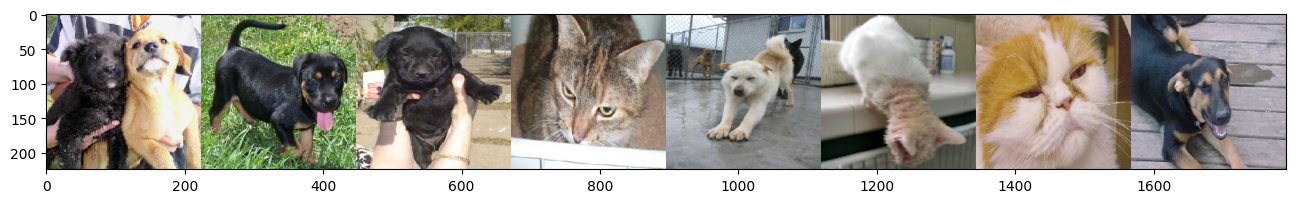

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

Antes de fazer o aprendizado por transferência, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede treinada por transferência posteriormente.

A rede que construiremos contém 4 camadas alternadas de convolução e max-pooling, seguidas por um dropout após cada par de conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será o AdaDelta. Várias coisas sobre essa rede podem ser alteradas para obter um melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, e por isso não é necessário gastar muito tempo tentando otimizar essa rede.

Ao compilar a rede, vamos executar model.summary() para obter uma visão geral de suas camadas.

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhões de pesos e vieses (os parâmetros). A maioria deles está direcionada para a camada totalmente conectada "dense_5" antes do softmax.

Agora podemos prosseguir e treinar nosso modelo por 10 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4957 - loss: 0.7142 - val_accuracy: 0.5333 - val_loss: 0.6878
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5280 - loss: 0.6873 - val_accuracy: 0.5900 - val_loss: 0.6645
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5969 - loss: 0.6643 - val_accuracy: 0.6433 - val_loss: 0.6368
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6176 - loss: 0.6480 - val_accuracy: 0.6767 - val_loss: 0.6045
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6243 - loss: 0.6288 - val_accuracy: 0.6833 - val_loss: 0.5952
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6725 - loss: 0.6007 - val_accuracy: 0.6967 - val_loss: 0.5805
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7010 - loss: 0.5723 - val_accuracy: 0.7100 - val_loss: 0.5521
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7267 - loss: 0.5615 - val_accuracy: 0.70

Vamos plotar a perda de validação e a precisão de validação ao longo do tempo.

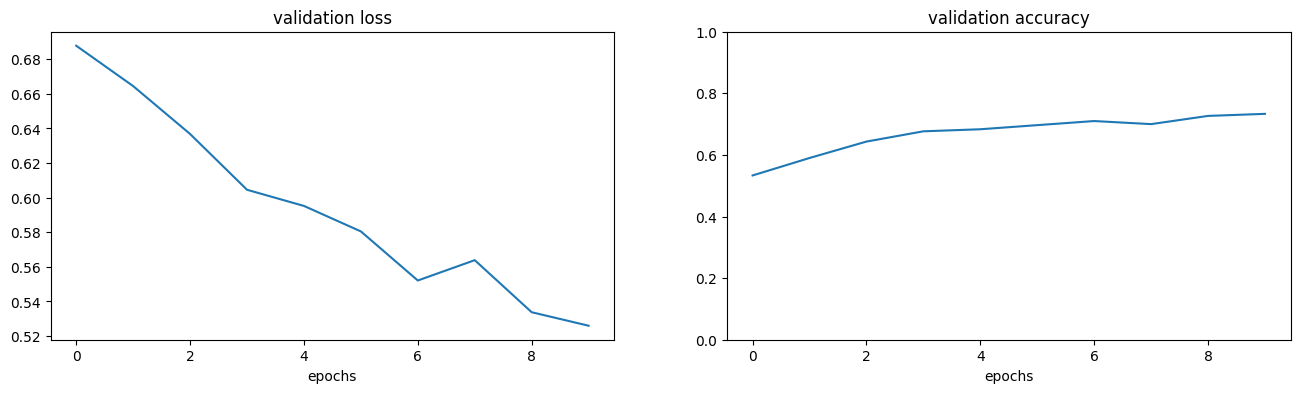

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a realmente aumentar após cerca de 16 épocas, embora a precisão de validação permaneça aproximadamente entre 55% e 75%. Isso sugere que nosso modelo começa a sobreajustar por volta desse ponto, e o melhor desempenho teria sido alcançado se tivéssemos parado mais cedo. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6206328272819519
Test accuracy: 0.6666666865348816


Finalmente, vemos que alcançamos uma precisão (top-1) de cerca de 66%. Isso não é tão ruim para 2000 imagens, considerando que, se usássemos uma estratégia ingênua de fazer palpites aleatórios, teríamos obtido apenas cerca de 1% de precisão

## Aprendizado por transferência começando com uma rede existente

Agora podemos passar para a principal estratégia de treinamento de um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do Keras, que foi treinado no ImageNet e cujos pesos foram salvos online. Se esta for a sua primeira vez carregando o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede esteja carregada, podemos novamente inspecionar as camadas com o método summary().



In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros está armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma taxa de erro top-5 de 8,8%, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão top-1 — equivalente à métrica de precisão que temos usado (que a principal previsão está correta) — é de 73%. Isso é especialmente impressionante, pois não são apenas 97, mas 1000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados PetImages.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG desde sua camada de entrada até a penúltima camada e, em seguida, trabalhar com isso, em vez de modificar diretamente o objeto VGG. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe Model do Keras para inicializar um novo modelo cuja camada de entrada é a mesma do VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência, e assim não precisamos nos preocupar com sobrecarga de memória

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos retreinar essa rede, model_new, no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova camada no final, com a expectativa de que as características aprendidas no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente melhor do que o que podemos treinar com nosso conjunto de dados limitado.

Ao definir a flag trainable como falsa em cada camada (exceto na nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos, e simplesmente treinamos os pesos na única camada no final. Em alguns casos, é desejável não congelar todas as camadas pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar finamente algumas das camadas do VGG junto com o novo classificador, ou possivelmente todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do PetImages, faremos apenas a extração de características, temendo que o ajuste fino excessivo com este conjunto de dados possa causar sobreajuste. Mas talvez estejamos errados? Um bom exercício seria tentar ambos e comparar os resultados.

Então, vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda que na nossa primeira rede, para uma comparação justa. Em seguida, executamos summary novamente para observar a arquitetura da rede

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto pela última camada, que antes era um softmax de 1000 neurônios e foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que é, na verdade, apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, prosseguimos e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também acompanhamos seu histórico à medida que avançamos.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.5363 - loss: 0.8560 - val_accuracy: 0.5700 - val_loss: 0.6436
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 695ms/step - accuracy: 0.6469 - loss: 0.6005 - val_accuracy: 0.8033 - val_loss: 0.4665
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 706ms/step - accuracy: 0.8004 - loss: 0.4597 - val_accuracy: 0.8400 - val_loss: 0.4150
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 718ms/step - accuracy: 0.8587 - loss: 0.4049 - val_accuracy: 0.8433 - val_loss: 0.3864
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 842ms/step - accuracy: 0.8758 - loss: 0.3560 - val_accuracy: 0.8500 - val_loss: 0.3627
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 853ms/step - accuracy: 0.8687 - loss: 0.3407 - val_accuracy: 0.8500 - val_loss: 0.3471
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 748ms/step - accuracy: 0.8791 - loss: 0.3250 - val_accuracy: 0.8667 - val_loss: 0.3419
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 732ms/step - accuracy: 0.8866 - loss: 0.3113 - val_accurac

Nossa precisão de validação fica próxima de 86% no final, o que é uma melhoria de mais de 20% em relação à rede original treinada do zero (o que significa que fazemos a previsão errada em 15% das amostras, em vez de 35%).

Vale notar também que essa rede treina um pouco mais rápido do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque congelar os pesos elimina a necessidade de retropropagar através de todas essas camadas, economizando tempo de execução.

Vamos plotar novamente a perda de validação e a precisão, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo treinado por transferência (em verde).

Aqui está o código para fazer isso:

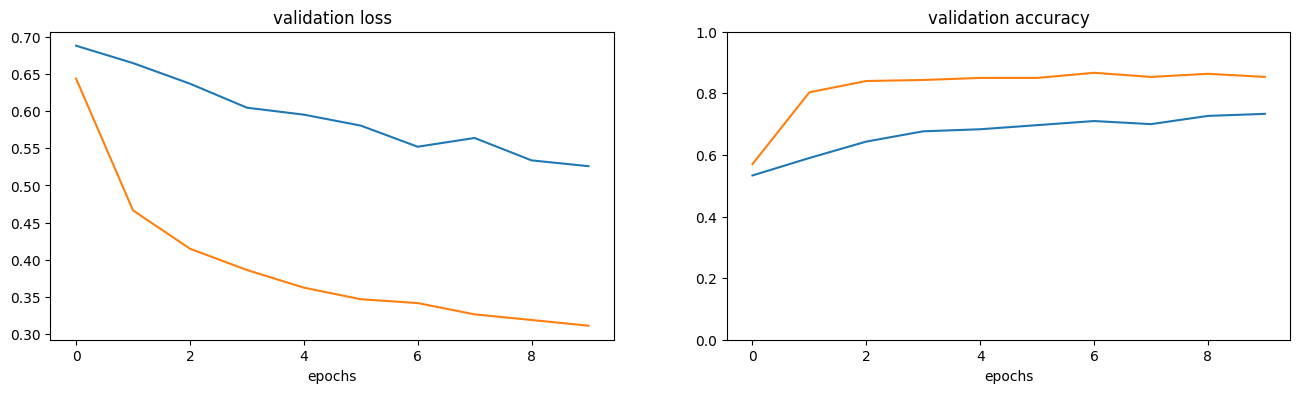

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a sobreajustar por volta da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo alcançou aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais dropout, mas certamente não teríamos alcançado a melhoria de mais de 30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.30147162079811096
Test accuracy: 0.8866666555404663


In [ ]:
# lista os arquivos disponíveis dentro do diretorio Dog


def list_files_in_directory(directory):
  """Lists files in a given directory.

  Args:
    directory: The path to the directory.

  Returns:
    A list of filenames in the directory, or None if the directory doesn't exist.
  """
  if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' not found.")
    return None

  files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  return files

# Example usage
files_in_dog_directory = list_files_in_directory('PetImages/Dog/')

if files_in_dog_directory:
  print("Files in 'PetImages/Dog/' directory:")
  for file in files_in_dog_directory:
    print(file)

Files in 'PetImages/Dog/' directory:
8828.jpg
3012.jpg
11332.jpg
1615.jpg
4882.jpg
12241.jpg
6332.jpg
3854.jpg
7268.jpg
6577.jpg
4657.jpg
5483.jpg
2405.jpg
11477.jpg
536.jpg
9895.jpg
6467.jpg
10640.jpg
12121.jpg
1421.jpg
7395.jpg
9305.jpg
4819.jpg
2210.jpg
9411.jpg
5330.jpg
3848.jpg
11816.jpg
10385.jpg
651.jpg
997.jpg
11717.jpg
12104.jpg
6840.jpg
6275.jpg
2187.jpg
11126.jpg
3218.jpg
107.jpg
2461.jpg
10583.jpg
36.jpg
10827.jpg
2657.jpg
10617.jpg
210.jpg
2624.jpg
6195.jpg
10874.jpg
1877.jpg
2245.jpg
6899.jpg
2846.jpg
6966.jpg
9935.jpg
9367.jpg
4464.jpg
11603.jpg
6376.jpg
1280.jpg
6334.jpg
10368.jpg
2508.jpg
6939.jpg
10881.jpg
1940.jpg
7986.jpg
2729.jpg
8934.jpg
5565.jpg
4476.jpg
432.jpg
4299.jpg
8906.jpg
3243.jpg
1629.jpg
5873.jpg
2971.jpg
4190.jpg
11879.jpg
9269.jpg
9710.jpg
11036.jpg
1435.jpg
10475.jpg
9317.jpg
2358.jpg
1817.jpg
7684.jpg
9908.jpg
10729.jpg
6444.jpg
9424.jpg
10161.jpg
11568.jpg
4656.jpg
8682.jpg
2937.jpg
12311.jpg
2916.jpg
8488.jpg
7036.jpg
6873.jpg
9878.jpg
5977.jpg
29

Para prever uma nova imagem, basta executar o seguinte código para obter as probabilidades para cada classe:

In [ ]:
# retorna o percentual de probabilidade avaliando a imagem PetImages/Dog/7909.jpg


img, x = get_image('PetImages/Dog/7909.jpg')
probabilities = model_new.predict([x])

# Get the predicted class index
predicted_class_index = np.argmax(probabilities[0])

# Get the probability of the predicted class
predicted_probability = probabilities[0][predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Probability of predicted class: {predicted_probability}")
print(f"Percentage probability: {predicted_probability * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class index: 0
Probability of predicted class: 1.0
Percentage probability: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: PetImages/Cat/10921.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: PetImages/Cat/4400.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: PetImages/Cat/4952.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: PetImages/Cat/846.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: PetImages/Cat/6405.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: PetImages/Cat/7485.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: PetImages/Cat/4659.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: PetImages/Cat/5869.jpg, Predicted class: 1, Probability: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: PetImages/Cat/236.jpg, Predicted class: 0, Probability: 88.21%
1/1 ━━━━━━━━

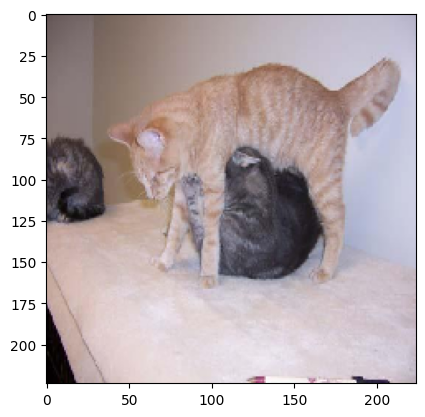

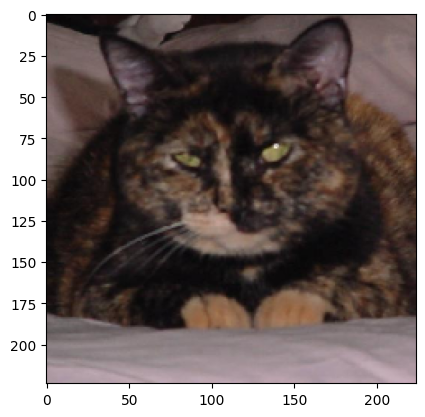

In [ ]:
# analisa as 100 primeiras imagens do diretorio PetImages/Dog/ e mostre a probabilidade de cada imagem



# Analyze the first 100 images in PetImages/Dog/
min_probability = 1.0  # Initialize with a high value
min_probability_image = None
img = 0
dog_image_dir = 'PetImages/Cat/'
dog_images = [os.path.join(dog_image_dir, f) for f in os.listdir(dog_image_dir) if os.path.isfile(os.path.join(dog_image_dir, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))][:10]


for image_path in dog_images:
    try:
        img, x = get_image(image_path)
        probabilities = model_new.predict([x])
        predicted_class_index = np.argmax(probabilities[0])
        predicted_probability = probabilities[0][predicted_class_index]
        print(f"Image: {image_path}, Predicted class: {predicted_class_index}, Probability: {predicted_probability * 100:.2f}%")
        if predicted_probability < min_probability:
            min_probability = predicted_probability
            min_probability_image = image_path

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue # Skip to the next image if there is an error

if min_probability_image:
    print(f"The image with the lowest probability is: {min_probability_image}")
    print(f"Probability: {min_probability * 100:.2f}%")

    # Now you can display the image
    try:
      img = image.load_img(min_probability_image, target_size=(224, 224))
      plt.imshow(img)
      plt.show()
      img = image.load_img("PetImages/Cat/5869.jpg", target_size=(224, 224))
      plt.imshow(img)
      plt.show()
    except Exception as e:
      print(f"Error displaying the image: {e}")
else:
    print("No images were processed successfully.")

### Melhorando os resultados

78,2% de precisão top-1 em 97 classes, aproximadamente distribuídas uniformemente, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que alcançou 73% de precisão top-1 em 1000 classes. No entanto, é muito melhor do que conseguimos com nossa rede original, e há espaço para melhorias. Algumas técnicas que poderiam ter melhorado nosso desempenho:

Usar aumento de dados: aumento refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, mudanças de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância para tais distorções.
Usar um otimizador diferente, adicionar mais regularização/dropout e outros hiperparâmetros.
Treinar por mais tempo (claro).
Um exemplo mais avançado de aprendizado por transferência no Keras, envolvendo aumento de dados para um pequeno conjunto de dados de 2 classes, pode ser encontrado no blog do Keras. [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).